In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


## Download Datset

In [3]:
dataset_name = 'facades' #'edges2shoes'
_URL = f'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(f'{dataset_name}.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), f'{dataset_name}/')

## Input Pipeline
Although Tensorflow Datasets contain this dataset but the masks and real images are not ordered in pair and is therefore not fit for purpose. Thus, we will use the image pipeline from Tensorflow tutorial at https://www.tensorflow.org/tutorials/generative/pix2pix. 

In [4]:
image_shape = (256, 256, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [5]:
BATCH_SIZE = 1
BUFFER_SIZE = 400

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    if dataset_name == 'facades':
        real_image = image[:, :w, :]
        input_image = image[:, w:, :]
    elif dataset_name == 'edges2shoes':
        real_image = image[:, w:, :]
        input_image = image[:, :w, :]       
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

#@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1).repeat()


In [6]:
class GaussianSampling(layers.Layer):        
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=(1,8), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon

        return samples

class BICYCLEGAN():
    def __init__(self, input_shape, load_path = ''):
        self.input_shape = input_shape
        self.z_dim = 8

        # Input
        images_A_1 = layers.Input(shape=input_shape, name='ImageA_1')
        images_B_1 = layers.Input(shape=input_shape, name='ImageB_1')
        images_A_2 = layers.Input(shape=input_shape, name='ImageA_2')
        images_B_2 = layers.Input(shape=input_shape, name='ImageB_2')
        z_random = layers.Input(shape=(self.z_dim,), name='z')
        
        # discriminator
        self.discriminator_1 = self.build_discriminator()
        self.discriminator_2 = self.build_discriminator()
        self.encoder = self.build_encoder()
        self.generator = self.build_generator()

        
        # cVAE-GAN
        z_encode, self.mean_encode, self.logvar_encode = self.encoder(images_B_1)
        kl_loss =  - 0.5 * tf.reduce_sum(1 + self.logvar_encode - \
                                          tf.square(self.mean_encode) - tf.exp(self.logvar_encode))
        
        fake_B_encode = self.generator([images_A_1, z_encode])
        encode_fake = self.discriminator_1(fake_B_encode)
        encode_real = self.discriminator_1(images_B_1)
        self.patch_size = encode_fake.shape[1]
        self.cvae_gan = Model(inputs=[images_A_1, images_B_1],
                              outputs=[encode_real, encode_fake, fake_B_encode, kl_loss])
        
        # cLR-GAN
        fake_B_random = self.generator([images_A_2, z_random])
        _, mean_random, _ = self.encoder(fake_B_random)
        random_fake = self.discriminator_2(fake_B_random)
        random_real = self.discriminator_2(images_B_2)        
        
        self.clr_gan = Model(inputs=[images_A_2, images_B_2, z_random], 
                             outputs=[random_real, random_fake, mean_random])
        
        self.LAMBDA_IMAGE = 10
        self.LAMBDA_LATENT = 0.5
        self.LAMBDA_KL = 0.01

        self.optimizer_d1 = Adam(1e-4, 0.5)
        self.optimizer_d2 = Adam(1e-4, 0.5)
        self.optimizer_generator = Adam(1e-4, 0.5)
        self.optimizer_encoder = Adam(1e-4, 0.5)
        
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.mse = tf.keras.losses.MeanSquaredError()

        checkpoint_path = f"./checkpoints/bicycle_{dataset_name}"
        self.ckpt = tf.train.Checkpoint(generator = self.generator,
                                   discriminator_1 = self.discriminator_1,
                                   discriminator_2 = self.discriminator_2,
                                   encoder = self.encoder)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, checkpoint_path, max_to_keep=40)
        if load_path:
            self.load_checkpoint(load_path)
            
    def load_checkpoint(self, ckpt_path):
        self.ckpt.restore(ckpt_path)
        
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        #initializer = tf.keras.initializers.GlorotNormal()
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        #initializer = tf.keras.initializers.GlorotNormal()
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def build_encoder(self):
        DIM = 64
        input_image = layers.Input(shape=image_shape)
        x = self.downsample(DIM, 4, norm=False)(input_image) 
        x = self.downsample(2*DIM, 4)(x) 
        x = self.downsample(4*DIM, 4)(x) 
        x = self.downsample(8*DIM, 4)(x) 
        x = self.downsample(8*DIM, 4)(x) 
        x = self.downsample(8*DIM, 4)(x) 
        x = layers.Flatten()(x)
        mean = layers.Dense(self.z_dim, name='mean')(x)
        logvar = layers.Dense(self.z_dim, name='logvar')(x)
        z = GaussianSampling(name='z')([mean, logvar])
        return Model(input_image, [z, mean, logvar], name='encoder')

    def build_generator(self):

        DIM = 64

        input_image = layers.Input(shape=image_shape, name='input_image')
        input_z = layers.Input(shape=(self.z_dim,), name='z')
        
        z = layers.Reshape((1,1, self.z_dim))(input_z)
        z_tiles = tf.tile(z, [self.batch_size, self.input_shape[0], 
                              self.input_shape[1], self.z_dim])
        x = layers.Concatenate()([input_image, z_tiles])
        down1 = self.downsample(DIM, 4, norm=False)(x) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM


        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
        concat6 = layers.Concatenate()([up6, down6])   

        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6) 
        concat5 = layers.Concatenate()([up5, down5]) 

        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5) 
        concat4 = layers.Concatenate()([up4, down4]) 

        up3 = self.upsample(4*DIM, 4)(concat4) 
        concat3 = layers.Concatenate()([up3, down3]) 

        up2 = self.upsample(2*DIM, 4)(concat3) 
        concat2 = layers.Concatenate()([up2, down2]) 

        up1 = self.upsample(DIM, 4)(concat2) 
        concat1 = layers.Concatenate()([up1, down1]) 

        output_image = tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))

        return Model([input_image, input_z], output_image, name='generator')         
    
    def build_discriminator(self):
        DIM = 64
        input_image_B = layers.Input(shape=image_shape)
        
        x = self.downsample(DIM, 4, norm=False)(input_image_B) 
        x = self.downsample(2*DIM, 4)(x) 
        x = self.downsample(4*DIM, 4)(x) 
        x = self.downsample(8*DIM, 4, strides=1)(x) 
        output = layers.Conv2D(1, 4)(x)

        return Model(input_image_B, output, name='discriminator')     
    

    def train_step(self, images_A_1, images_B_1, images_A_2, images_B_2):
        z = tf.random.normal((self.batch_size, self.z_dim))    
        real_labels = tf.ones((self.batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((self.batch_size, self.patch_size, self.patch_size, 1))

        with tf.GradientTape() as tape_e, tf.GradientTape() as tape_g,\
        tf.GradientTape() as tape_d1, tf.GradientTape() as tape_d2:
            encode_real, encode_fake, fake_B_encode, kl_loss = self.cvae_gan([images_A_1, images_B_1])
            random_real, random_fake, mean_random = self.clr_gan([images_A_2, images_B_2, z])
            
            # discriminator loss
            self.d1_loss = self.mse(real_labels, encode_real) + self.mse(fake_labels, encode_fake) 
            gradients_d1 = tape_d1.gradient(self.d1_loss, self.discriminator_1.trainable_variables)
            self.optimizer_d1.apply_gradients(zip(gradients_d1, self.discriminator_1.trainable_variables))

            self.d2_loss = self.mse(real_labels, random_real) + self.mse(fake_labels, random_fake) 
            gradients_d2 = tape_d2.gradient(self.d2_loss, self.discriminator_2.trainable_variables)
            self.optimizer_d2.apply_gradients(zip(gradients_d2, self.discriminator_2.trainable_variables))
            
            # Generator and Encoder loss
            self.gan_1_loss = self.mse(real_labels, encode_fake)
            self.gan_2_loss = self.mse(real_labels, random_fake)
            self.image_loss = self.LAMBDA_IMAGE * self.mae(images_B_1, fake_B_encode)
            self.kl_loss = self.LAMBDA_KL*kl_loss
            self.latent_loss = self.LAMBDA_LATENT *self.mae(z, mean_random)
            
            encoder_loss = self.gan_1_loss + self.gan_2_loss + self.image_loss + self.kl_loss
            generator_loss = encoder_loss + self.latent_loss
            
            gradients_generator = tape_g.gradient(generator_loss, self.generator.trainable_variables)
            self.optimizer_generator.apply_gradients(zip(gradients_generator, self.generator.trainable_variables))

            gradients_encoder = tape_e.gradient(encoder_loss, self.encoder.trainable_variables)
            self.optimizer_encoder.apply_gradients(zip(gradients_encoder, self.encoder.trainable_variables))
            
        return generator_loss
        
    def train(self, data_generator, test_data_generator, batch_size, steps, interval=100):


        self.batch_size = batch_size
        for i in range(steps):

            images_A_1, images_B_1 = next(data_generator)
            images_A_2, images_B_2 = next(data_generator)
            self.train_step(images_A_1, images_B_1, images_A_2, images_B_2)

            if i%interval == 0:
                ckpt_save_path = self.ckpt_manager.save()
                print ('Saving checkpoint for step {} at {}'.format(i, ckpt_save_path))
                msg = "Step {}: g1_loss {:.4f} g2_loss {:.4f} img_loss {:.4f} latent_loss {:.4f} kl_loss {:.4f}"\
                .format(i, self.gan_1_loss, self.gan_2_loss, self.image_loss,  self.latent_loss, self.kl_loss)
                print(msg)
                msg = "d1_loss {:.4f} d2_loss {:.4f}"\
                .format(self.d1_loss, self.d2_loss)
                print(msg)

                # test
                for _ in range(3):
                    fake_images = []
                    val_images = next(test_data_generator) 
                    for _ in range(4):
                        z = tf.random.normal((batch_size, self.z_dim))    
                        fake_image = self.generator.predict([val_images[0], z])
                        fake_images.append(fake_image)
                    fake_images = np.concatenate(fake_images, axis=0)
                    self.plot_images(val_images, fake_images)
                    

        
    def plot_images(self, real_images, fake_images):   
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            ax[0].imshow((real_images[0][row]+1)/2)
            ax[0].axis('off') 
            ax[1].imshow((real_images[1][row]+1)/2)
            ax[1].axis('off') 
            for i in range(4):
                ax[i+2].imshow((fake_images[i]+1)/2)
                ax[i+2].axis('off') 
        plt.show()


gan = BICYCLEGAN(image_shape)

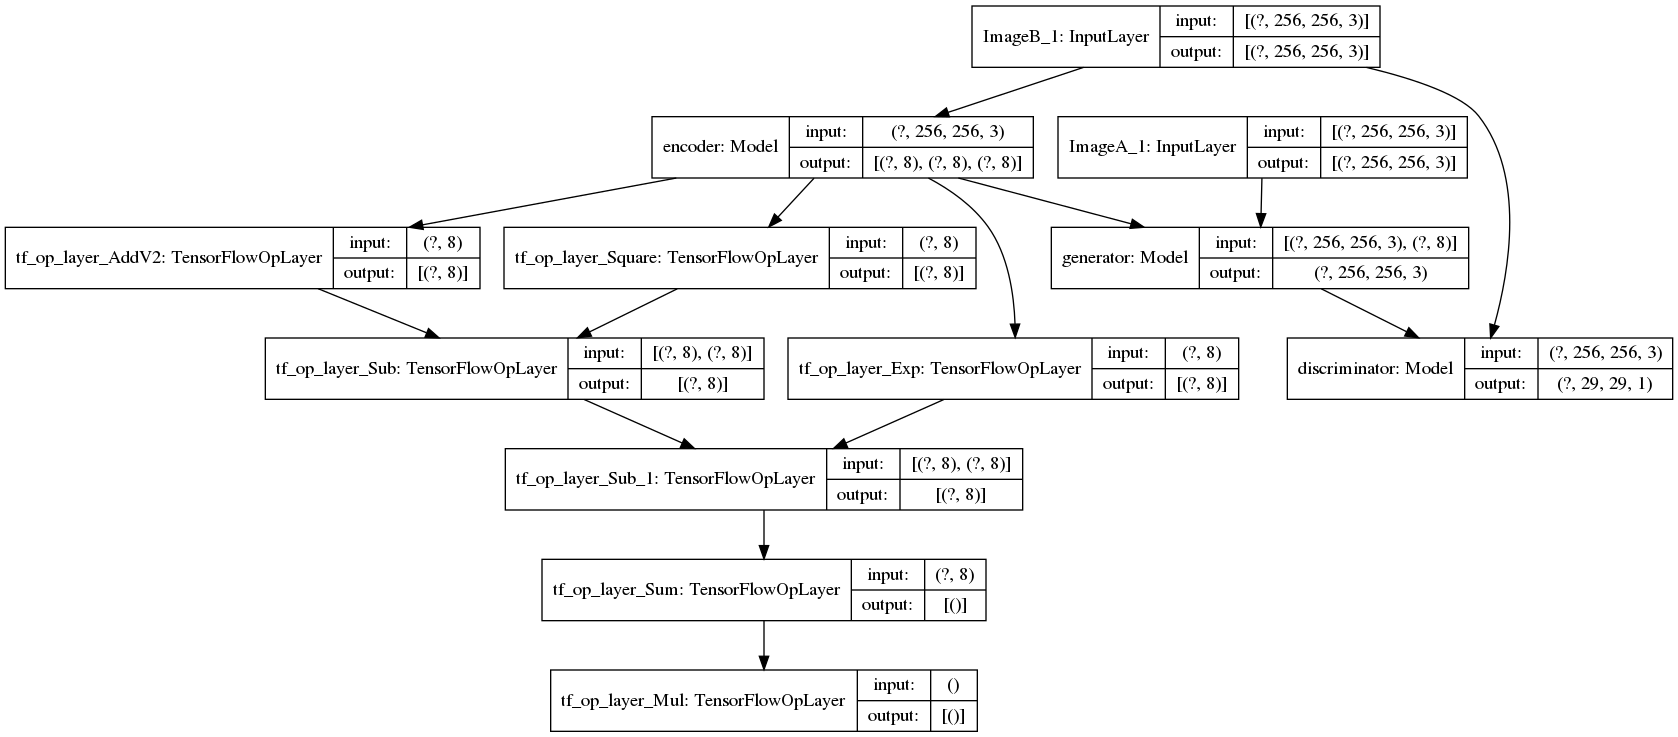

In [7]:
tf.keras.utils.plot_model(gan.cvae_gan, show_shapes=True)


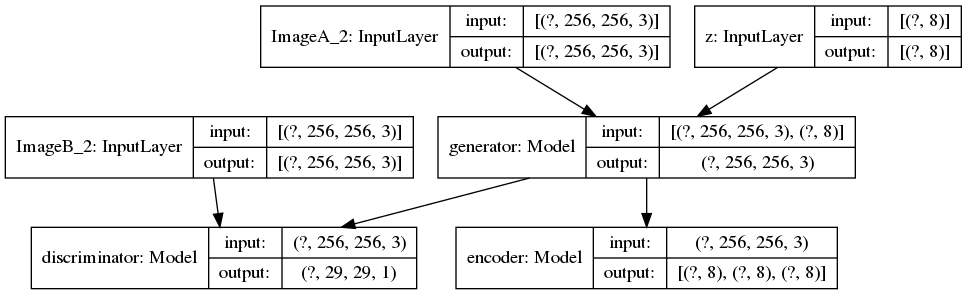

In [8]:
tf.keras.utils.plot_model(gan.clr_gan, show_shapes=True)

In [ ]:
gan.train(iter(train_dataset), iter(test_dataset), BATCH_SIZE, 40000, 500)

In [49]:
test_iterator = iter(test_dataset)
#gan.load_checkpoint('./checkpoints/facades/ckpt-79')

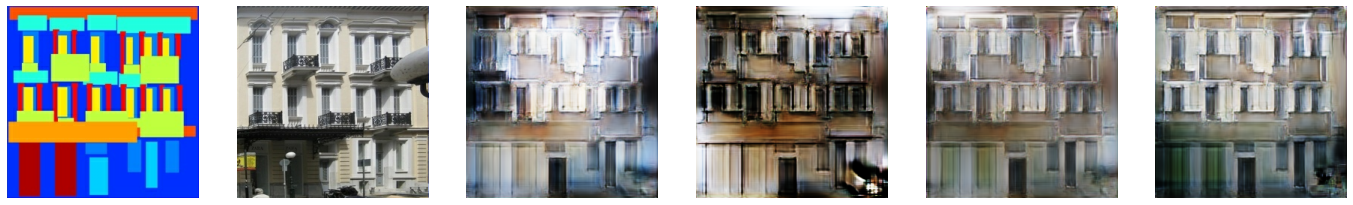

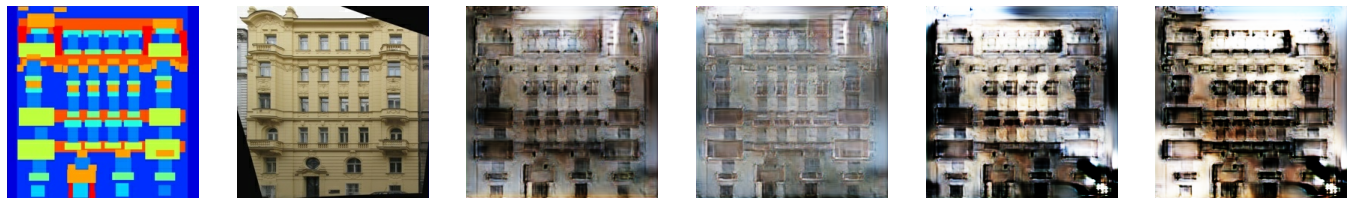

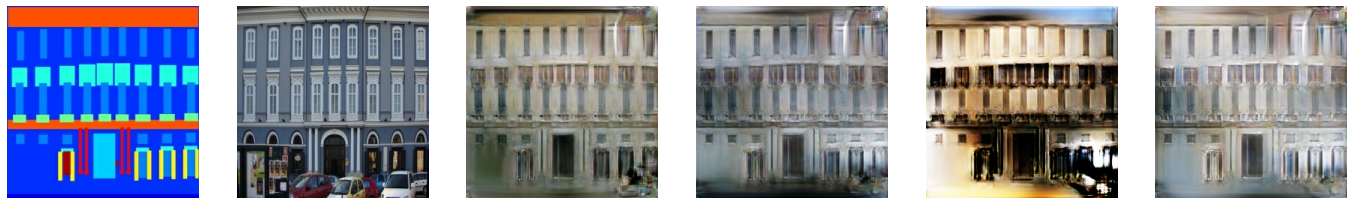

In [53]:
for _ in range(3):
    fake_images = []
    val_images = next(test_iterator) 
    for _ in range(4):
        z = -tf.random.normal((1, 8))
        fake_image = gan.generator.predict([val_images[0], z])
        fake_images.append(fake_image)
    fake_images = np.concatenate(fake_images, axis=0)
    gan.plot_images(val_images, fake_images)
